In [1]:
# Importações de bibliotecas gerais
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importações do scikit-learn para modelos, métricas e validação cruzada
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Importações do LightGBM
import lightgbm as lgb

# Importação do imbalanced-learn para balanceamento de classes
from imblearn.under_sampling import RandomUnderSampler

base = pd.read_parquet('dfCleaned.parquet')
base.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
1,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
2,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
3,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
4,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0


In [2]:
base.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [3]:
import pandas as pd

correlation_matrix = base.corr()

# Filtrar apenas as correlações com o target
target_correlation = correlation_matrix["DiffWalk"].sort_values(ascending=False)

print(target_correlation)


DiffWalk                1.000000
PhysHlth                0.467861
GenHlth                 0.442264
MentHlth                0.220960
HeartDiseaseorAttack    0.211268
HighBP                  0.209257
Age                     0.208915
Diabetes_012            0.199677
Stroke                  0.178390
HighChol                0.138773
BMI                     0.135693
Smoker                  0.123734
NoDocbcCost             0.112179
CholCheck               0.038229
AnyHealthcare           0.007112
HvyAlcoholConsump      -0.032321
Fruits                 -0.042569
Sex                    -0.058686
Veggies                -0.076708
Education              -0.186756
PhysActivity           -0.238116
Income                 -0.306169
Name: DiffWalk, dtype: float64


In [4]:
from sklearn.preprocessing import MinMaxScaler

def normalizar_coluna(df, nome_coluna):
    # Inicializar o MinMaxScaler
    scaler = MinMaxScaler()
    
    # Selecionar a coluna especificada
    coluna = df[[nome_coluna]]
    
    # Normalizar a coluna
    coluna_normalizada = scaler.fit_transform(coluna)
    
    # Retornar a coluna normalizada
    return coluna_normalizada
normalizar_coluna(base,'GenHlth')
normalizar_coluna(base,'Age')
normalizar_coluna(base,'MentHlth')
normalizar_coluna(base,'PhysHlth')
normalizar_coluna(base,'Income')
normalizar_coluna(base,'Education')
normalizar_coluna(base,'BMI')
normalizar_coluna(base,'Diabetes_012')

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])

In [5]:
#dropando colunas com menor corrrelação e a target
X = base.drop(columns=['AnyHealthcare', 'HvyAlcoholConsump', 'Fruits', 'Sex', 'Veggies', 'CholCheck', 'DiffWalk'])
y = base.DiffWalk

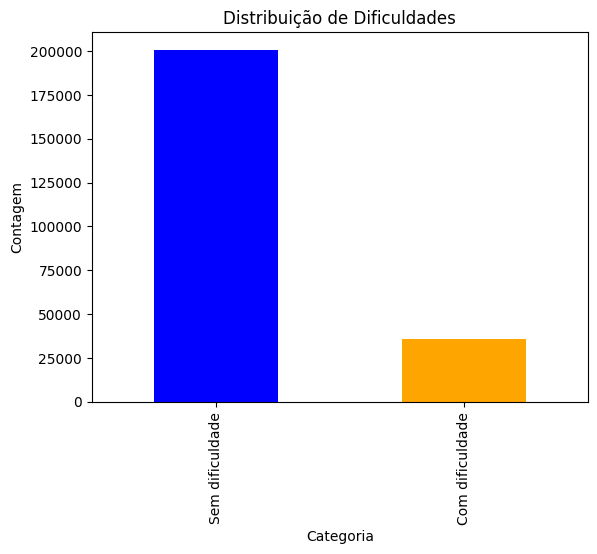

In [6]:


# Supondo que y seja uma série pandas com os valores 0.0 e 1.0
# Exemplo: y = pd.Series([0.0, 1.0, 0.0, 1.0, 1.0, 0.0])

# Substituir valores numéricos por labels
labels = {0.0: "Sem dificuldade", 1.0: "Com dificuldade"}
y_labels = y.replace(labels)

# Contar a frequência dos valores
value_counts = y_labels.value_counts()

# Plotar gráfico de barras
value_counts.plot(kind='bar', color=['blue', 'orange'])

# Adicionar título e labels
plt.title('Distribuição de Dificuldades')
plt.xlabel('Categoria')
plt.ylabel('Contagem')

# Mostrar gráfico
plt.show()

#trocar grafico e semantica
#add labels

In [7]:
y_labels.value_counts()

DiffWalk
Sem dificuldade    200707
Com dificuldade     35777
Name: count, dtype: int64

### Dividindo entre treino e teste

In [8]:
# Importando o train_test_split
from sklearn.model_selection import train_test_split
# Fazendo a separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, 
                                                    random_state=42)
# Verificando a proporção na base de treino
(y_train.value_counts()/y_train.shape[0])*100

DiffWalk
0.0    84.841332
1.0    15.158668
Name: count, dtype: float64

In [9]:
#renomeando para ficar mais entendível
y_train = y_train.replace({0: 'Não tem dificuldade', 1: 'Tem dificuldade'})
y_test = y_test.replace({0: 'Não tem dificuldade', 1: 'Tem dificuldade'})


Knn desbalanceado


In [10]:
# Treino
knn = KNeighborsClassifier(n_neighbors=3)

# Treinando o modelo
knn.fit(X_train, y_train)

# Fazendo previsões nos dados de teste
y_pred = knn.predict(X_test)

# Avaliando o desempenho do modelo nos dados de teste
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia: {accuracy:.2f}")
print("Relatório de Classificação:")
print(report)

Acurácia: 0.86
Relatório de Classificação:
                     precision    recall  f1-score   support

Não tem dificuldade       0.90      0.94      0.92     66281
    Tem dificuldade       0.57      0.42      0.48     11759

           accuracy                           0.86     78040
          macro avg       0.73      0.68      0.70     78040
       weighted avg       0.85      0.86      0.86     78040



Naive Bayes desbalanceado

In [11]:


# Testando um modelo Naive Bayes
nb = GaussianNB()
nb.fit(X_test, y_test)
y_pred_nb = nb.predict(X_test)

# Avaliando o desempenho
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)

print(f"Acurácia (Naive Bayes): {accuracy_nb:.2f}")
print(report_nb)


Acurácia (Naive Bayes): 0.83
                     precision    recall  f1-score   support

Não tem dificuldade       0.93      0.86      0.90     66281
    Tem dificuldade       0.46      0.65      0.54     11759

           accuracy                           0.83     78040
          macro avg       0.70      0.76      0.72     78040
       weighted avg       0.86      0.83      0.84     78040



Random Forest desbalanceado

In [12]:


# Testando um modelo Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Avaliando o desempenho
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"Acurácia (Random Forest): {accuracy_rf:.2f}")
print(report_rf)


Acurácia (Random Forest): 0.88
                     precision    recall  f1-score   support

Não tem dificuldade       0.91      0.96      0.93     66281
    Tem dificuldade       0.63      0.44      0.52     11759

           accuracy                           0.88     78040
          macro avg       0.77      0.70      0.72     78040
       weighted avg       0.86      0.88      0.87     78040



# Balanceado

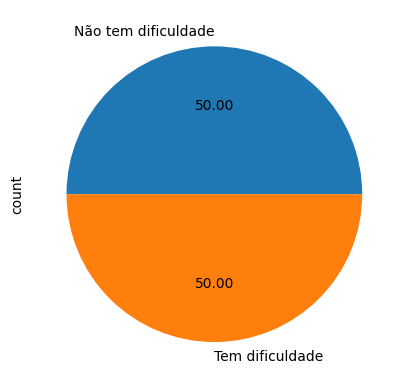

In [13]:

# Definindo o RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
# Aplicando para X e y
X_res, y_res = rus.fit_resample(X_train, y_train)
# Visualizando graficamente
y_res.value_counts().plot.pie(autopct='%.2f');
# Supondo que y_res e y_test sejam os seus rótulos para o conjunto de treino e teste

# Substituindo 0 e 1 por 'Não tem dificuldade' e 'Tem dificuldade'
y_res = y_res.replace({0: 'Não tem dificuldade', 1: 'Tem dificuldade'})
y_test = y_test.replace({0: 'Não tem dificuldade', 1: 'Tem dificuldade'})



In [14]:
y_res.value_counts()

DiffWalk
Não tem dificuldade    24018
Tem dificuldade        24018
Name: count, dtype: int64

# Knn


## Knn treino 

Acurácia knn com dados de treino: 0.83
Relatório de Classificação balanceado:
                     precision    recall  f1-score   support

Não tem dificuldade       0.81      0.88      0.84     24018
    Tem dificuldade       0.86      0.79      0.83     24018

           accuracy                           0.83     48036
          macro avg       0.84      0.83      0.83     48036
       weighted avg       0.84      0.83      0.83     48036



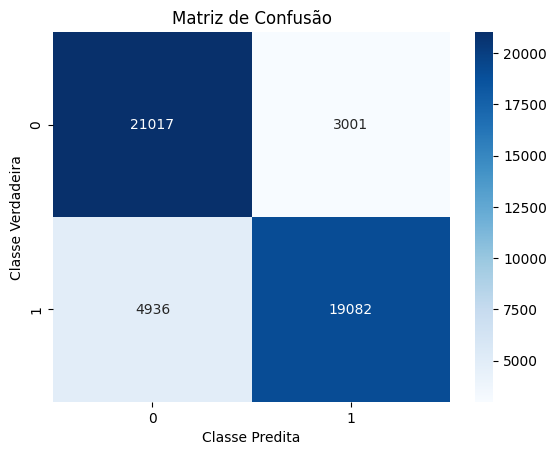

In [15]:
# Criando o modelo KNN
knn_balanced_train = KNeighborsClassifier(n_neighbors=5)

# Treinando o modelo
knn_balanced_train.fit(X_res, y_res)

# Fazendo previsões nos dados de teste
y_pred2_train = knn_balanced_train.predict(X_res)

# Avaliando o desempenho do modelo
accuracy_train = accuracy_score(y_res, y_pred2_train)
report_train = classification_report(y_res, y_pred2_train)
conf_matrix = confusion_matrix(y_res, y_pred2_train)

print(f"Acurácia knn com dados de treino: {accuracy_train:.2f}")
print("Relatório de Classificação balanceado:")
print(report_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.show()

## Knn teste

Acurácia KNN no conjunto de teste: 0.81
Relatório de Classificação no conjunto de teste:
                     precision    recall  f1-score   support

Não tem dificuldade       0.94      0.82      0.88     66281
    Tem dificuldade       0.42      0.73      0.53     11759

           accuracy                           0.81     78040
          macro avg       0.68      0.78      0.71     78040
       weighted avg       0.87      0.81      0.83     78040



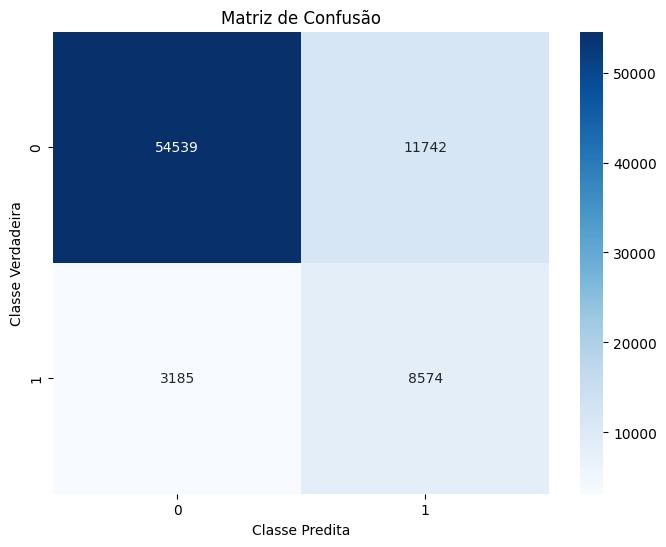

In [16]:

# Criando o modelo KNN
knn_balanced_test = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Treinando o modelo no conjunto de treino balanceado
knn_balanced_test.fit(X_res, y_res)

# Fazendo previsões nos dados de teste não balanceados
y_pred2_test = knn_balanced_test.predict(X_test)

# Avaliando o desempenho do modelo no conjunto de teste não balanceado
accuracy_test = accuracy_score(y_test, y_pred2_test)
report_test = classification_report(y_test, y_pred2_test)
conf_matrix = confusion_matrix(y_test, y_pred2_test)

print(f"Acurácia KNN no conjunto de teste: {accuracy_test:.2f}")
print("Relatório de Classificação no conjunto de teste:")
print(report_test)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.show()


## Knn com gridSearch

Melhores parâmetros encontrados: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
F1 Score no conjunto de teste: 0.7231606027953701
Resultados para KNN com gridsearch:
                     precision    recall  f1-score   support

Não tem dificuldade       0.95      0.83      0.89     66281
    Tem dificuldade       0.44      0.75      0.56     11759

           accuracy                           0.82     78040
          macro avg       0.70      0.79      0.72     78040
       weighted avg       0.87      0.82      0.84     78040



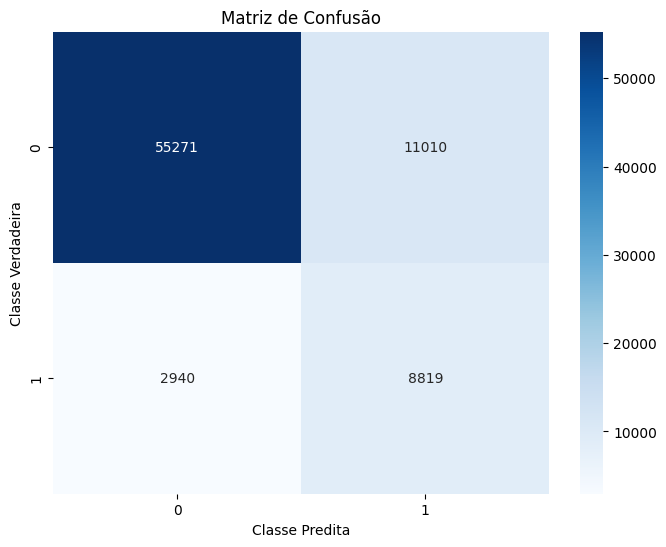

In [17]:


# Definir o modelo KNN
knn = KNeighborsClassifier()

# Definir os parâmetros que queremos otimizar
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Implementar o GridSearchCV com f1_score como métrica
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='f1_macro')

# Treinar o modelo com o GridSearch
grid_search.fit(X_res, y_res)

# Melhor combinação de hiperparâmetros
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# Fazer previsões no conjunto de teste
y_pred = grid_search.predict(X_test)

# Avaliar o modelo com f1_score
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score no conjunto de teste:", f1)

print("Resultados para KNN com gridsearch:")
# Exibir um relatório detalhado
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.show()


# Random forest

## Random forest com peso ajustado para aumentar o recall da 1.0

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score

# Ajustando o modelo Random Forest com pesos de classe modificados
rf = RandomForestClassifier(
    random_state=42,
    n_estimators=300,           # Mantendo o número de árvores
    max_depth=9,                # Mantendo a profundidade
    min_samples_split=25,       # Aumentando o número mínimo de amostras para split
    min_samples_leaf=15,        # Aumentando o número mínimo de amostras em folha
    max_features='sqrt',        # Limitando o número de features usadas
    class_weight={'Não tem dificuldade': 1, 'Tem dificuldade': 1.010} # Reduzindo o peso da classe minoritária
)

# Criando o objeto de validação cruzada com 5 folds estratificados
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usando cross_val_predict para obter previsões para cada fold (dados de treino)
y_pred_train = cross_val_predict(rf, X_res, y_res, cv=cv)

# Treinando o modelo nos dados de treino completos
rf.fit(X_res, y_res)

# Fazendo previsões nos dados de teste
y_pred_test = rf.predict(X_test)

# Calculando e exibindo o relatório de classificação para dados de treino
accuracy_train = accuracy_score(y_res, y_pred_train)
report_train = classification_report(y_res, y_pred_train)

# Calculando e exibindo o relatório de classificação para dados de teste
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print(f"Acurácia nos dados de treino Random forest com peso maior para o que tem dificuldade: {accuracy_train:.2f}")
print(report_train)

print(f"Acurácia nos dados de teste Random forest com peso maior para o que tem dificuldade: {accuracy_test:.2f}")
print(report_test)


Acurácia nos dados de treino Random forest com peso maior para o que tem dificuldade: 0.81
                     precision    recall  f1-score   support

Não tem dificuldade       0.81      0.81      0.81     24018
    Tem dificuldade       0.81      0.81      0.81     24018

           accuracy                           0.81     48036
          macro avg       0.81      0.81      0.81     48036
       weighted avg       0.81      0.81      0.81     48036

Acurácia nos dados de teste Random forest com peso maior para o que tem dificuldade: 0.81
                     precision    recall  f1-score   support

Não tem dificuldade       0.96      0.81      0.88     66281
    Tem dificuldade       0.43      0.80      0.56     11759

           accuracy                           0.81     78040
          macro avg       0.70      0.81      0.72     78040
       weighted avg       0.88      0.81      0.83     78040



# LGBM 

In [19]:


# Instanciando o modelo LightGBM com parâmetros iniciais
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight={'Não tem dificuldade': 1, 'Tem dificuldade': 1.010} # Ajustando o peso da classe minoritária
)

# Criando o objeto de validação cruzada com 5 folds estratificados
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usando cross_val_predict para obter previsões para cada fold (dados de treino)
y_pred_train = cross_val_predict(lgb_model, X_res, y_res, cv=cv)

# Treinando o modelo nos dados de treino completos
lgb_model.fit(X_res, y_res)

# Fazendo previsões nos dados de teste
y_pred_test = lgb_model.predict(X_test)

# Calculando e exibindo o relatório de classificação para dados de treino
accuracy_train = accuracy_score(y_res, y_pred_train)
report_train = classification_report(y_res, y_pred_train)

# Calculando e exibindo o relatório de classificação para dados de teste
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print(f"Acurácia nos dados de treino: {accuracy_train:.2f}")
print(report_train)

print(f"Acurácia nos dados de teste: {accuracy_test:.2f}")
print(report_test)


[LightGBM] [Info] Number of positive: 19214, number of negative: 19214
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 38428, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502488 -> initscore=0.009950
[LightGBM] [Info] Start training from score 0.009950
[LightGBM] [Info] Number of positive: 19215, number of negative: 19214
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 38429, number of used features: 15
[LightGBM] [Info] [bin

## LGBM utilizando gridserach

In [20]:

# Instanciando o modelo LightGBM com random_state fixo
lgb_model = lgb.LGBMClassifier(random_state=42)

# Definindo os parâmetros a serem testados no Grid Search (parâmetros reduzidos)
param_grid = {
    'n_estimators': [300],
    'max_depth': [8, 10],
    'learning_rate': [0.1],
    'scale_pos_weight': [1.5],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Configurando o Grid Search com validação cruzada
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)

# Ajustando o modelo aos dados de treino
grid_search.fit(X_res, y_res)

# Exibindo os melhores parâmetros encontrados
print(f"Melhores parâmetros: {grid_search.best_params_}")

# Avaliando o modelo nos dados de teste
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
print('Classification report LGBM')
report_test = classification_report(y_test, y_pred_test)
print(report_test)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Info] Number of positive: 16012, number of negative: 16012
[LightGBM] [Info] Number of positive: 16012, number of negative: 16012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 32024, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 32024, number of used features: 15
[LightGBM] [Info

/Users/alanalins/pisi3/Diabetes-PISI3/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alanalins/pisi3/Diabetes-PISI3/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alanalins/pisi3/Diabetes-PISI3/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alanalins/pisi3/Diabetes-PISI3/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=300, scale_pos_weight=1.5, subsample=0.8; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, scale_pos_weight=1.5, subsample=0.8; total time=   5.1s


/Users/alanalins/pisi3/Diabetes-PISI3/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/alanalins/pisi3/Diabetes-PISI3/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alanalins/pisi3/Diabetes-PISI3/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alanalins/pisi3/Diabetes-PISI3/.venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
 

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, scale_pos_weight=1.5, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=300, scale_pos_weight=1.5, subsample=0.8; total time=   5.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, scale_pos_weight=1.5, subsample=0.8; total time=   5.8s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=300, scale_pos_weight=1.5, subsample=0.8; total time=   5.8s
[LightGBM] [Info] Number of positive: 24018, number of negative: 24018
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 48036, number of used features: 15
[LightGBM] [Info] [binary:B

# SVM

In [ ]:
"""
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
svm_model = SVC(
    kernel='rbf',
    C=2.0,             # Aumentando o parâmetro de regularização para reduzir falsos negativos
    gamma='scale',     # Mantendo gamma padrão
    class_weight={'Não tem dificuldade': 1, 'Tem dificuldade': 2},  # Usando pesos para classes 0 e 1
    probability=True,  # Habilitando probabilidades para ajuste do threshold
    random_state=42
)

# Treinando o modelo nos dados de treino completos
svm_model.fit(X_res, y_res)

# Prevendo probabilidades em vez de rótulos binários
y_proba_test = svm_model.predict_proba(X_test)[:, 1]

# Ajustando o threshold para aumentar o recall e reduzir falsos negativos
threshold = 0.4  # Pode ajustar esse valor para balancear precisão e recall
y_pred_test = (y_proba_test >= threshold).astype(int)

# Convertendo rótulos previstos de 0/1 para strings
y_pred_test = pd.Series(y_pred_test).replace({0: 'Não tem dificuldade', 1: 'Tem dificuldade'})

# Certificando-se de que y_test também está em formato textual
y_test = y_test.replace({0: 'Não tem dificuldade', 1: 'Tem dificuldade'})

# Calculando e exibindo o relatório de classificação para dados de teste
accuracy_test = accuracy_score(y_test, y_pred_test)
report_test = classification_report(y_test, y_pred_test)

print(f"Acurácia nos dados de teste SVM:  {accuracy_test:.2f}")
print(report_test)
"""

# Naive bayes

In [ ]:


# Testando um modelo Naive Bayes
nb_balanced = GaussianNB()
nb_balanced.fit(X_res, y_res)
y_pred_nb_balanced = nb_balanced.predict(X_test)

# Avaliando o desempenho
accuracy_nb_balanced = accuracy_score(y_test, y_pred_nb_balanced)
report_nb_balanced = classification_report(y_test, y_pred_nb_balanced)

print(f"Acurácia (Naive Bayes): {accuracy_nb_balanced:.2f}")
print(report_nb_balanced)


Acurácia (Naive Bayes): 0.81
                     precision    recall  f1-score   support

Não tem dificuldade       0.94      0.82      0.88     66281
    Tem dificuldade       0.42      0.72      0.53     11759

           accuracy                           0.81     78040
          macro avg       0.68      0.77      0.70     78040
       weighted avg       0.86      0.81      0.83     78040



Naive bayes com gridSearch

In [ ]:


# Instanciando o modelo Gaussian Naive Bayes
nb_model = GaussianNB()

# Realizando a validação cruzada com 5 folds
cv_scores = cross_val_score(nb_model, X_res, y_res, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Treinando o modelo nos dados de treino completos após a validação cruzada
nb_model.fit(X_res, y_res)

# Fazendo previsões nos dados de teste
y_pred_nb_balanced = nb_model.predict(X_test)

# Avaliando o desempenho nos dados de teste
accuracy_nb_balanced = accuracy_score(y_test, y_pred_nb_balanced)
report_nb_balanced = classification_report(y_test, y_pred_nb_balanced)

# Exibindo os resultados da validação cruzada e do teste
print(f"Acurácia média da validação cruzada  Naive bayes: {cv_scores.mean():.2f}")
print(f"Desvio padrão da validação cruzada: {cv_scores.std():.2f}")
print(f"Acurácia nos dados de teste: {accuracy_nb_balanced:.2f}")
print(report_nb_balanced)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Acurácia média da validação cruzada  Naive bayes: 0.78
Desvio padrão da validação cruzada: 0.00
Acurácia nos dados de teste: 0.81
                     precision    recall  f1-score   support

Não tem dificuldade       0.94      0.82      0.88     66281
    Tem dificuldade       0.42      0.72      0.53     11759

           accuracy                           0.81     78040
          macro avg       0.68      0.77      0.70     78040
       weighted avg       0.86      0.81      0.83     78040

